In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim

In [2]:
weather = pd.read_excel("data_full_fixed.xlsx", index_col="timestamp")
core_weather = weather[["TC2MECDMeBT2MEC"]].copy()
core_weather.columns = ["temp_mean"]
core_weather

,temp_mean
timestamp,
1995-01-01,0.995445
1995-01-02,-1.031221
1995-01-03,-1.252888
1995-01-04,-3.638305
1995-01-05,-7.954970
...,...
2023-06-06,19.585445
2023-06-07,18.856280
2023-06-08,19.459612


In [3]:
core_weather["target"] = core_weather["temp_mean"].shift(-10)
core_weather = core_weather.dropna()


train = core_weather[:"2015-12-31"]
test = core_weather["2016-1-1":]

In [4]:
test

,temp_mean,target
timestamp,,
2016-01-01,6.735445,7.368778
2016-01-02,5.824612,5.078779
2016-01-03,6.485445,2.506279
2016-01-04,5.352112,0.851279
2016-01-05,4.179613,1.363362
...,...,...
2023-05-27,18.363361,19.585445
2023-05-28,18.094194,18.856280
2023-05-29,18.206280,19.459612


In [5]:
train

,temp_mean,target
timestamp,,
1995-01-01,0.995445,3.083779
1995-01-02,-1.031221,0.047529
1995-01-03,-1.252888,-1.963721
1995-01-04,-3.638305,-3.899138
1995-01-05,-7.954970,-0.898304
...,...,...
2015-12-27,6.402945,3.966279
2015-12-28,5.851695,3.981696
2015-12-29,6.160862,6.686696


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)



In [7]:
train_scaled

array([[-0.42172227, -0.3130893 ],
       [-0.52714742, -0.47103194],
       [-0.53867829, -0.57565513],
       ...,
       [-0.15302254, -0.12566921],
       [-0.08611308, -0.03871087],
       [-0.17047059, -0.04126843]])

In [8]:
test_scaled

array([[-0.12313329, -0.09018797],
       [-0.17051394, -0.20931141],
       [-0.13613806, -0.34313027],
       ...,
       [ 0.4735679 ,  0.53876497],
       [ 0.39707815,  0.59999568],
       [ 0.43680765,  0.62511648]])

In [9]:
# tensors
def to_tensors(data):
    x = torch.tensor(data[:, 0].reshape(-1, 1, 1), dtype=torch.float32)  
    y = torch.tensor(data[:, 1], dtype=torch.float32)
    return x, y

train_input, train_target = to_tensors(train_scaled)
test_input, test_target = to_tensors(test_scaled)

In [10]:
# LSTM 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

In [11]:
input_size = 1  
hidden_size = 200
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
#Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input)
    loss = criterion(output.squeeze(), train_target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/100, Loss: 0.1511046439409256
Epoch 2/100, Loss: 0.14873585104942322
Epoch 3/100, Loss: 0.14647625386714935
Epoch 4/100, Loss: 0.14432057738304138
Epoch 5/100, Loss: 0.1422644406557083
Epoch 6/100, Loss: 0.1403038650751114
Epoch 7/100, Loss: 0.1384350061416626
Epoch 8/100, Loss: 0.13665418326854706
Epoch 9/100, Loss: 0.13495813310146332
Epoch 10/100, Loss: 0.13334377110004425
Epoch 11/100, Loss: 0.13180837035179138
Epoch 12/100, Loss: 0.1303495168685913
Epoch 13/100, Loss: 0.1289651095867157
Epoch 14/100, Loss: 0.12765324115753174
Epoch 15/100, Loss: 0.12641209363937378
Epoch 16/100, Loss: 0.12523987889289856
Epoch 17/100, Loss: 0.12413458526134491
Epoch 18/100, Loss: 0.12309379130601883
Epoch 19/100, Loss: 0.12211460620164871
Epoch 20/100, Loss: 0.1211933046579361
Epoch 21/100, Loss: 0.12032539397478104
Epoch 22/100, Loss: 0.11950540542602539
Epoch 23/100, Loss: 0.11872690916061401
Epoch 24/100, Loss: 0.11798257380723953
Epoch 25/100, Loss: 0.1172642856836319
Epoch 26/100, Los

In [13]:
#Testing
model.eval()
with torch.no_grad():
    predictions = model(test_input)
    test_loss = criterion(predictions.squeeze(), test_target)
    print(f"Test Loss: {test_loss.item()}")



Test Loss: 0.05142000690102577


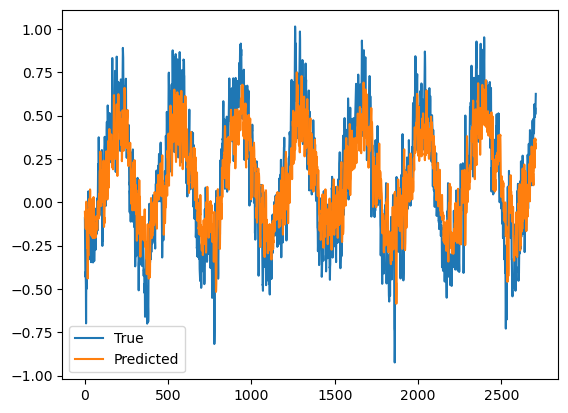

In [14]:
plt.plot(test_target.numpy(), label="True")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()


In [15]:
epochs = 150
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input)
    loss = criterion(output.squeeze(), train_target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/150, Loss: 0.053661469370126724
Epoch 2/150, Loss: 0.0534864217042923
Epoch 3/150, Loss: 0.0533355288207531
Epoch 4/150, Loss: 0.053207121789455414
Epoch 5/150, Loss: 0.05309942364692688
Epoch 6/150, Loss: 0.05301051214337349
Epoch 7/150, Loss: 0.052938416600227356
Epoch 8/150, Loss: 0.052881211042404175
Epoch 9/150, Loss: 0.052837055176496506
Epoch 10/150, Loss: 0.05280424654483795
Epoch 11/150, Loss: 0.052781179547309875
Epoch 12/150, Loss: 0.05276630446314812
Epoch 13/150, Loss: 0.05275816470384598
Epoch 14/150, Loss: 0.052755340933799744
Epoch 15/150, Loss: 0.052756547927856445
Epoch 16/150, Loss: 0.05276069417595863
Epoch 17/150, Loss: 0.0527668334543705
Epoch 18/150, Loss: 0.05277419090270996
Epoch 19/150, Loss: 0.052782122045755386
Epoch 20/150, Loss: 0.052790068089962006
Epoch 21/150, Loss: 0.05279755964875221
Epoch 22/150, Loss: 0.05280425399541855
Epoch 23/150, Loss: 0.05280989408493042
Epoch 24/150, Loss: 0.05281434208154678
Epoch 25/150, Loss: 0.05281755328178406
Ep

In [16]:
model.eval()
with torch.no_grad():
    predictions = model(test_input)
    test_loss = criterion(predictions.squeeze(), test_target)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.05044516921043396


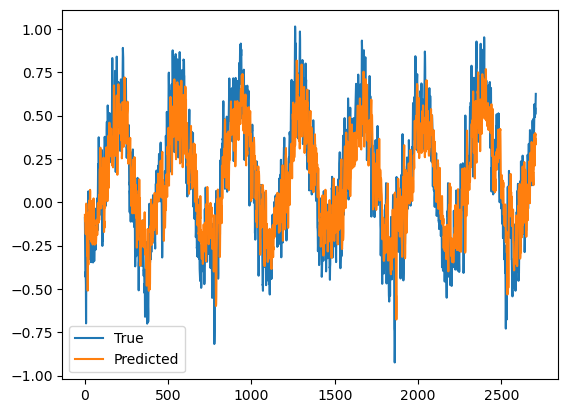

In [17]:
plt.plot(test_target.numpy(), label="True")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()

In [18]:
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input)
    loss = criterion(output.squeeze(), train_target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/200, Loss: 0.05274337902665138
Epoch 2/200, Loss: 0.05274331197142601
Epoch 3/200, Loss: 0.05274324119091034
Epoch 4/200, Loss: 0.052743181586265564
Epoch 5/200, Loss: 0.05274311825633049
Epoch 6/200, Loss: 0.05274304747581482
Epoch 7/200, Loss: 0.052742987871170044
Epoch 8/200, Loss: 0.05274292454123497
Epoch 9/200, Loss: 0.052742861211299896
Epoch 10/200, Loss: 0.052742794156074524
Epoch 11/200, Loss: 0.05274273455142975
Epoch 12/200, Loss: 0.052742671221494675
Epoch 13/200, Loss: 0.0527426116168499
Epoch 14/200, Loss: 0.05274254456162453
Epoch 15/200, Loss: 0.05274248123168945
Epoch 16/200, Loss: 0.052742425352334976
Epoch 17/200, Loss: 0.0527423620223999
Epoch 18/200, Loss: 0.05274230241775513
Epoch 19/200, Loss: 0.05274224281311035
Epoch 20/200, Loss: 0.052742183208465576
Epoch 21/200, Loss: 0.0527421273291111
Epoch 22/200, Loss: 0.05274206027388573
Epoch 23/200, Loss: 0.05274200066924095
Epoch 24/200, Loss: 0.05274194851517677
Epoch 25/200, Loss: 0.0527418851852417
Epoch 

In [19]:
model.eval()
with torch.no_grad():
    predictions = model(test_input)
    test_loss = criterion(predictions.squeeze(), test_target)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.05049413442611694


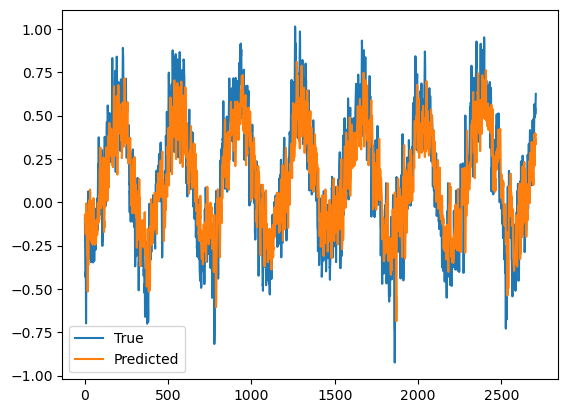

In [20]:
plt.plot(test_target.numpy(), label="True")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()

In [21]:
epochs = 250
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input)
    loss = criterion(output.squeeze(), train_target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/250, Loss: 0.052735522389411926
Epoch 2/250, Loss: 0.05273549631237984
Epoch 3/250, Loss: 0.052735473960638046
Epoch 4/250, Loss: 0.05273545905947685
Epoch 5/250, Loss: 0.05273543298244476
Epoch 6/250, Loss: 0.05273541808128357
Epoch 7/250, Loss: 0.05273539572954178
Epoch 8/250, Loss: 0.052735377103090286
Epoch 9/250, Loss: 0.052735358476638794
Epoch 10/250, Loss: 0.052735332399606705
Epoch 11/250, Loss: 0.05273531377315521
Epoch 12/250, Loss: 0.05273529514670372
Epoch 13/250, Loss: 0.05273527279496193
Epoch 14/250, Loss: 0.052735257893800735
Epoch 15/250, Loss: 0.05273523926734924
Epoch 16/250, Loss: 0.05273521691560745
Epoch 17/250, Loss: 0.05273519828915596
Epoch 18/250, Loss: 0.05273517966270447
Epoch 19/250, Loss: 0.052735161036252975
Epoch 20/250, Loss: 0.05273514240980148
Epoch 21/250, Loss: 0.05273512378334999
Epoch 22/250, Loss: 0.0527351088821888
Epoch 23/250, Loss: 0.05273508280515671
Epoch 24/250, Loss: 0.05273507162928581
Epoch 25/250, Loss: 0.05273505300283432
Epo

In [22]:
model.eval()
with torch.no_grad():
    predictions = model(test_input)
    test_loss = criterion(predictions.squeeze(), test_target)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.05051860585808754


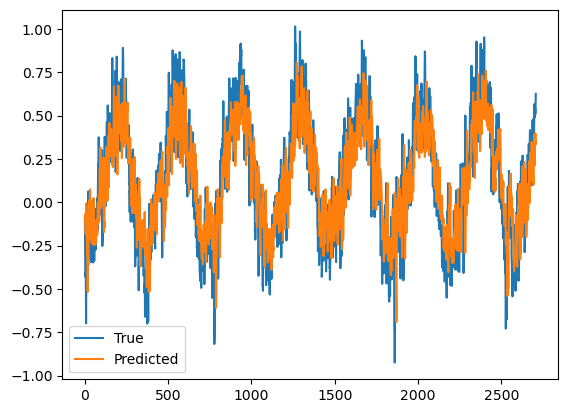

In [23]:
plt.plot(test_target.numpy(), label="True")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()